In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

In [2]:
if torch.cuda.is_available():     # Lựa chọn phần cứng huấn luyện là GPU nếu có thể
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

In [8]:
dataDir = 'D:\HK2_2021\TT_XLA\TAI LIEU LY THUYET\MedNIST\MedNIST'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
classNames= [ x for x in classNames if x!= 'README.md']
numClass = len(classNames)        # Số lượng class = số lượng của của thư mục con
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # Danh sách tên của các file trong dữ liệu
numEach = [len(imageFiles[i]) for i in range(numClass)]     # Số lượng mẫu cho từng class
imageFilesList = []               # Tạo một danh sách rỗng dùng để chứa tên các file ảnh
imageClass = []                   # Tạo một danh sách rỗng dùng để chứa tên các class 
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Tổng số ảnh trong dữ liệu
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # Kích thước mỗi ảnh
print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)


There are 58954 images in 6 distinct categories
Label names: ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


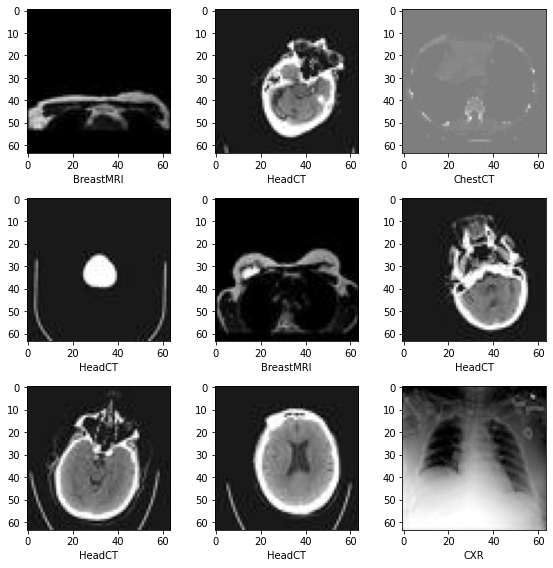

In [9]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Lấy ngẫu nhiên 9 ảnh
    im = Image.open(imageFilesList[k])                      #      và hiển thị chúng cùng với nhãn
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

In [10]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # đưa vào một ảnh đoc từ thư viện PIL, trả về một tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Giả sử ảnh không rỗng, chuẩn hoá dữ liệu vào khoảng [0 - 1]
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Đảm bảo dữ liệu mới có trị trung bình bằng 0
    return z

In [11]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # tải, chuẩn hoá dữ liệu và sắp xếp toàn bộ dữ liệu thành tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"  
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.972; Mean = -2.61e-09


In [13]:
validFrac = 0.1   # Định nghĩa số lượng mẫu của tập xác tực (theo tỷ lệ phần trăm)
testFrac = 0.1    # Định nghĩa số lượng mẫu của tập kiểm tra (theo tỷ lệ phần trăm)
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # chọn ảnh một cách ngẫu nhiên
    if rann < validFrac:
                validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Đến số lượng mẫu trong mỗi tập
nValid = len(validList)
nTest = len(testList)
print("Training images =", nTrain,"Validation =", nValid,"Testing =", nTest)

Training images = 47180 Validation = 5877 Testing = 5897


In [14]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

In [15]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Đưa vào kích thước của ảnh để khởi tạo mô hình   
        super(MedNet,self).__init__()  # Mở rộng class nn.Module cơ bản thành class MedNet 
        # Các tham số ở đây được định nghĩa là kiến trúc cuả các khối CNN, 
       # Mỗi điểm ảnh sẽ được một số bộ lọc CNN áp ụng lên đó; và convSize là số lượng của các điểm ảnh bao quanh điểm gốc trong phép nhân chập. 
       #Cuối cùng than số numNodesToFC sẽ khai báo số lượng đặc trưng còn sót lại trước khi chúng được xếp phẳng để đưa vào các lớp tiếp theo.
       # Mỗi bước Conv sẽ làm cho ảnh nhở hơn một chút (do đường viền ngoài của ảnh sẽ không được tính toán đến).

        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # Ảnh đầu vào là ảnh xám nên chỉ có một kênh, tức là channels in=1;  
        # Số lượng channel ngõ ra của một lớp sẽ chính là số lượng ngõ vào của lớp liến sau nó. 
        # Các biến cần học được lưu trữ thông qua  các trọng số kết nối hai lớp liền kề
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # Những tham số này định nghĩa số lượng của các nút ngõ ra cho mỗi mỗi lớp kết nối hoàn chỉnh.
        # Mỗi lớp phải đưa ra cùng số lượng các nút giống hệt số lượng nút cho input của lớp tiếp theo.
        # Lớp cuối cùng phải có cùng số nút với số lượng class cần thực hiện.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Lưu trữ các biến kết nối hai lớp liền kề.
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # Định nghĩa mạng noron và cách truyền từ input-output.
        # Phương thức này sử dụng lại các biến- các khối mô hình được định nghĩa ở phương thức  __init__.
        # Ngõ ra của các lớp được gán vào trong biến x và sau đó được đưa vào lớp tiếp theo.
        # Ở đây hàm tích cực được dùng là hàm Elu, đây là phiên bản mượt hơn của hàm tích cực ReLu.
        
        x = F.elu(self.cnv1(x)) # Đưa ảnh xám đầu vào đi vào lớp nhân chập đầu tiên
        x = F.elu(self.cnv2(x)) # Lấy ngõ ra của lớp thứ nhất đưa vào lớp thứ hai và áp dụng hàm tích cực.
        x = x.view(-1,self.num_flat_features(x)) # Làm phẳng kết quả ngõ ra
        x = F.elu(self.ful1(x)) # Đưa vào lớp fully connected và đi qua hàm tích cực
        x = F.elu(self.ful2(x)) # Đưa qua lớp fully connected thứ hai và đi qua hàm tích cực
        x = self.ful3(x)        # Kết nối với ngõ ra, ở đây không dùng hàm tích cực vì hàm mục tiêu sau này sẽ thực hiện việc này.
        return x

    def num_flat_features(self, x):  # Đếm số lượng nút tại một lớm
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

In [16]:
learnRate = 0.01          # Định nghĩa tốc độ học.
maxEpochs = 20            # Định nghĩa số epoch huấn luyện
t2vRatio = 1.2            # ________________________________________________________
t2vEpochs = 3             # __________________________________________
batchSize = 300           # Số lượng mẫu được dùng cho mỗi lần update. 
trainBats = nTrain // batchSize       # Số lượng các nhóm nhỏ được sử dụng huấn luyện trong mỗi Epoch
validBats = nValid // batchSize       # Số lượng các nhóm nhỏ được sử dụng để kiểm tra trong mỗi Epoch

testBats = -(-nTest // batchSize)     # Số lượng các nhóm nhỏ được sử dụng để đánh giá 

In [18]:
learnRate = 0.01          # Định nghĩa tốc độ học.
maxEpochs = 20            # Định nghĩa số epoch huấn luyện
t2vRatio = 1.2            # ________________________________________________________
t2vEpochs = 3             # __________________________________________
batchSize = 300           # Số lượng mẫu được dùng cho mỗi lần update. 
trainBats = nTrain // batchSize       # Số lượng các nhóm nhỏ được sử dụng huấn luyện trong mỗi Epoch
validBats = nValid // batchSize       # Số lượng các nhóm nhỏ được sử dụng để kiểm tra trong mỗi Epoch

testBats = -(-nTest // batchSize)     # Số lượng các nhóm nhỏ được sử dụng để đánh giá 

CEweights = torch.zeros(numClass)     # Tính toán để cân bằng dữ liệu .
for i in trainY.tolist():             # Đếm số mẫu trong mỗi Class
    CEweights[i].add_(1)        
CEweights = 1. / CEweights.clamp_(min=1.)                     # Tọng số phải tỷ lệ nghịch với số mẫu đếm được 
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # Đảm bảo tổng các trọng số bằng 1
opti = om.SGD(model.parameters(), lr = learnRate)   # Khởi tạo bộ huấn luyện


for i in range(maxEpochs):
    model.train()                     # Đặt model vào chế hộ huấn luyện
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # trộn data để xáo trộ dữ liêu cho mỗi epoch
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # lặp lại quá trình huấn luyện trên mỗi nhóm nhỏ
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Lấy dữ liệu để huấn luyện
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .lấy nhãn tương ứng        
        yOut = model(batX)            # Tính toán ngõ ra
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Tính toán hàm tổn thất
        epochLoss += loss.item()      # Thêm vào tổn thất chung của tập huấn luyện
        loss.backward()               # Lan truyền ngược giá trị tổn tất
        opti.step()                   # cập nhập trong số của mô hình
    validLoss = 0.
    permute = torch.randperm(nValid)  # Quá trính đánh giá khi kết thúc 1 epoch 
    validX = validX[permute,:,:,:]    # Lặp lại quá trình trên ngoại trừ việc lan truyền
    validY = validY[permute]          # ngược và cập nhập trọng số
    model.eval()                      # đặt chế độ eval cho mô hình
    with torch.no_grad():             # đóng băng chức năng gradient descent để không
        for j in range(validBats): # thay đổi mô hình
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Tính các tổn thất trung bình và in ra kết quả
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Kiểm tra bị overfitting hay chưa
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch =   0; Training loss = 0.0684; Validation loss = 0.0568
Epoch =   1; Training loss = 0.0489; Validation loss = 0.0444
Epoch =   2; Training loss = 0.0381; Validation loss = 0.0342
Epoch =   3; Training loss = 0.0311; Validation loss = 0.0284
Epoch =   4; Training loss = 0.0262; Validation loss = 0.0269
Epoch =   5; Training loss = 0.0228; Validation loss = 0.0233
Epoch =   6; Training loss = 0.0199; Validation loss = 0.0216
Epoch =   7; Training loss = 0.0175; Validation loss = 0.0194
Epoch =   8; Training loss = 0.0154; Validation loss = 0.0187
Epoch =   9; Training loss = 0.0139; Validation loss = 0.0175
Epoch =  10; Training loss = 0.0124; Validation loss = 0.0168
Validation loss too high; halting to prevent overfitting


In [19]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Tạo ma trận nhầm lẫn rỗng gồm 6 hàng và 6 cột
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # trộn dữ liệu đánh giá
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # lặp lại qúa trình test
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # truyền giá trị test vào mô hình
        pred = yOut.max(1,keepdim=True)[1]              # dự đoán dựa trên giá trị lớn nhất trả về
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Ghép đôi nhãn và dữ liệu dự đoán
            confuseMtx[j[0],j[1]] += 1                  # thực hiện việc đếm cho mỗi phần tử
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Tổng của các thành phần trên đường chéo chính
print("Correct predictions: ",correct,"of",nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)

Correct predictions:  5877 of 5897
Confusion Matrix:
[[ 956    0    5    0    0    0]
 [   0  893    0    0    0    0]
 [   3    0 1082    0    0    0]
 [   0    0    0 1009    5    2]
 [   0    0    0    0  948    3]
 [   0    0    0    0    2  989]]
['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


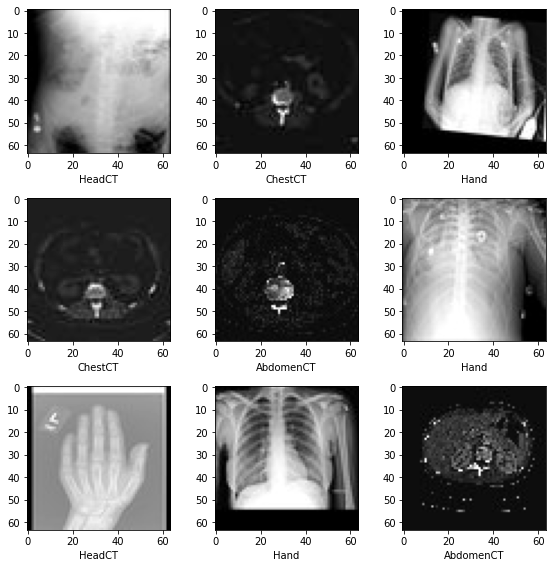

In [20]:
def scaleBack(x):               # Đưa vào một tenssor, chuẩn hoá về giá trị trong khoảng [0,1]
    if(x.min() < x.max()):      
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Chuyển đổi từ kiểu dữ liệu Pytourch Tensor sang kiểu dữ liệu numpy array

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Trộn dữ liệu
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Lặp lại với các nhóm dữ liệu nhỏ
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # truyền dữ liệu vào bên trong mô hình
    pred = yOut.max(1)[1].tolist()     # Dự đoán loại của mẫu
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # so sánh giá trị thực với giá trị dự đoán
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # hiển thị tên của nhãn
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()